In [82]:
import pandas as pd

boston = pd.read_csv("../../data/Boston.csv").rename({"Unnamed: 0": "Id"}, axis=1).set_index("Id")
boston["chas"].value_counts()

chas
0    471
1     35
Name: count, dtype: int64

In [83]:
med = boston["crim"].median()

crim01 = (boston["crim"] > med).astype(int)
boston["crim01"] = crim01

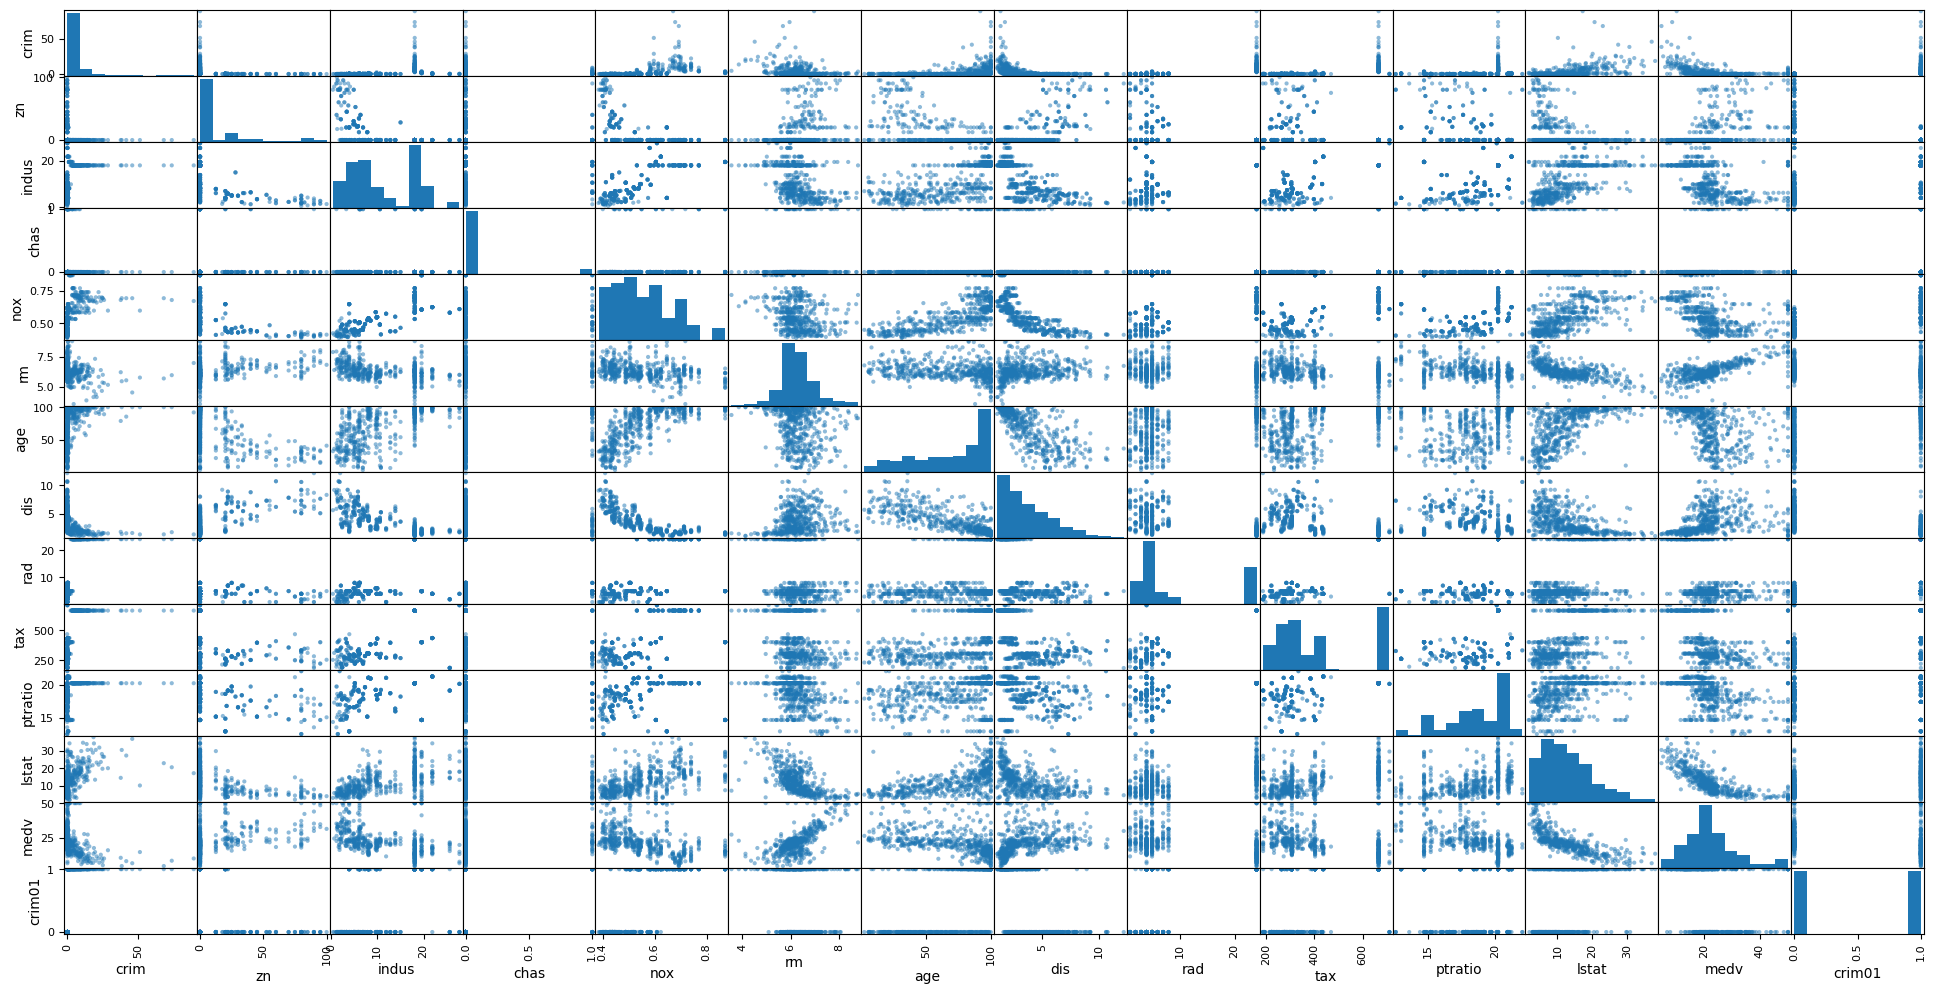

In [84]:
pd.plotting.scatter_matrix(boston, figsize=(24,12));

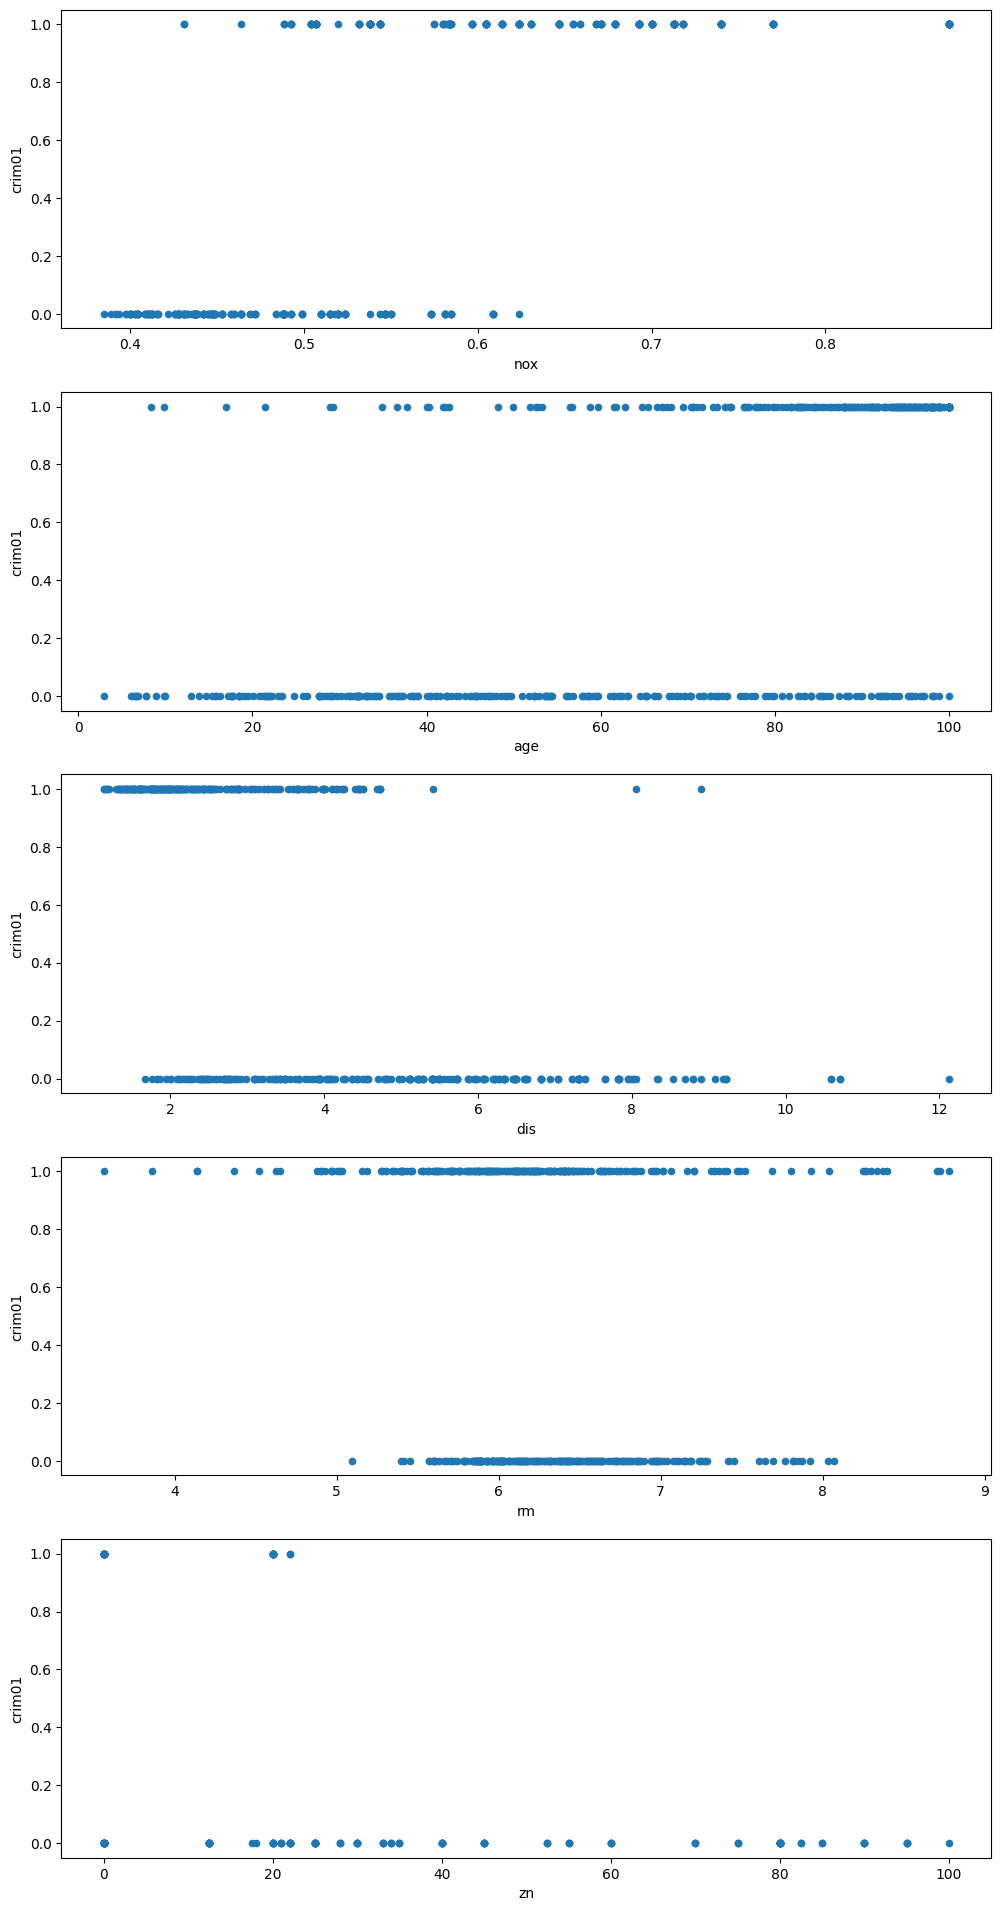

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 1, figsize=(12, 24))
i = 0

for pred in ("nox", "age", "dis", "rm", "zn"):
    boston.plot.scatter(pred, "crim01", ax=ax[i])
    i+=1

In [86]:
boston[["nox", "age", "dis", "rm", "zn", "crim"]].corr()

,nox,age,dis,rm,zn,crim
nox,1.000000,0.731470,-0.769230,-0.302188,-0.516604,0.420972
age,0.731470,1.000000,-0.747881,-0.240265,-0.569537,0.352734
dis,-0.769230,-0.747881,1.000000,0.205246,0.664408,-0.379670
rm,-0.302188,-0.240265,0.205246,1.000000,0.311991,-0.219247
zn,-0.516604,-0.569537,0.664408,0.311991,1.000000,-0.200469
crim,0.420972,0.352734,-0.379670,-0.219247,-0.200469,1.000000


nox, age, dis, rm, zn all show some relationship with crim01. However, since these variables, particularly nox, dis, and age, are correlated with one another, using all of them might introduce multicollinearity. Therefore, it may be more effective to select just one of these predictors to avoid redundancy and improve model interpretability.

In [87]:
def evaluate_confusion_df(confusion_df):
    # Extract values
    TP = confusion_df.loc[1, 1]
    FP = confusion_df.loc[1, 0]
    FN = confusion_df.loc[0, 1]
    TN = confusion_df.loc[0, 0]

    total = TP + FP + FN + TN
    accuracy = (TP + TN) / total if total else 0

    precision_up = TP / (TP + FP) if (TP + FP) else 0
    recall_up = TP / (TP + FN) if (TP + FN) else 0

    precision_down = TN / (TN + FN) if (TN + FN) else 0
    recall_down = TN / (TN + FP) if (TN + FP) else 0

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision (1): {precision_up * 100:.2f}%")
    print(f"Recall (1): {recall_up * 100:.2f}%")
    print(f"Precision (0): {precision_down * 100:.2f}%" if (TN + FN) else "Precision (0): Undefined (no 0 predictions)")
    print(f"Recall (0): {recall_down * 100:.2f}%" if (TN + FP) else "Recall (0): Undefined (no actual 0 cases)")

In [88]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (e.g., 70% train, 30% test)
boston_train, boston_test = train_test_split(boston, test_size=0.3, random_state=42, stratify=boston["crim01"])

In [89]:
from ISLP.models import ModelSpec as MS 

X_train = MS(["nox"]).fit_transform(boston_train)
X_test = MS(["nox"]).fit_transform(boston_test)

y = boston_train["crim01"] == 1

# LDA

In [90]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA  

lda = LDA()
lda.fit(X_train, y)

prob = lda.predict(X_test)

import numpy as np

labels = np.array([0]*boston_test.shape[0])
labels[prob>0.5] = 1

from ISLP import confusion_table

conf = confusion_table(labels, boston_test["crim01"])
conf

Truth,0,1
Predicted,,
0,68,15
1,8,61


In [91]:
print("LDA")
evaluate_confusion_df(conf)

LDA
Accuracy: 84.87%
Precision (1): 88.41%
Recall (1): 80.26%
Precision (0): 81.93%
Recall (0): 89.47%


# QDA

In [92]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 

qda = QDA(reg_param=0.1)
qda.fit(X_train, y)

prob = qda.predict(X_test)

labels = np.array([0]*boston_test.shape[0])
labels[prob>0.5] = 1

conf = confusion_table(labels, boston_test["crim01"])
conf

Truth,0,1
Predicted,,
0,68,15
1,8,61


In [93]:
print("QDA")
evaluate_confusion_df(conf)

QDA
Accuracy: 84.87%
Precision (1): 88.41%
Recall (1): 80.26%
Precision (0): 81.93%
Recall (0): 89.47%


# Logistic Regression

In [94]:
import statsmodels.api as sm 

results = sm.GLM(y, X_train, family=sm.families.Binomial()).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 crim01   No. Observations:                  354
Model:                            GLM   Df Residuals:                      352
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -113.69
Date:                Wed, 23 Jul 2025   Deviance:                       227.37
Time:                        18:50:08   Pearson chi2:                     233.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5248
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -16.3405      1.731     -9.439      0.000     -19.733     -12.948
nox           30.5337      3.267      9.345      0.000      24.130      36.937
==============================================================================
"""

In [95]:
prob = results.predict(X_test)

labels = np.array([0]*boston_test.shape[0])
labels[prob>0.5] = 1

conf = confusion_table(labels, boston_test["crim01"])
conf

Truth,0,1
Predicted,,
0,64,7
1,12,69


In [96]:
print("Logistic Regression")
evaluate_confusion_df(conf)

Logistic Regression
Accuracy: 87.50%
Precision (1): 85.19%
Recall (1): 90.79%
Precision (0): 90.14%
Recall (0): 84.21%


# Naive Bayes

In [97]:
from sklearn.naive_bayes import GaussianNB as NB

nb = NB()
nb.fit(X_train, y)

prob = nb.predict(X_test)

labels = np.array([0]*boston_test.shape[0])
labels[prob>0.5] = 1

conf = confusion_table(labels, boston_test["crim01"])
conf

Truth,0,1
Predicted,,
0,68,15
1,8,61


In [98]:
print("Naive Bayes")
evaluate_confusion_df(conf)

Naive Bayes
Accuracy: 84.87%
Precision (1): 88.41%
Recall (1): 80.26%
Precision (0): 81.93%
Recall (0): 89.47%


# KNN

In [99]:
from sklearn.neighbors import KNeighborsClassifier as KNN 

knn = KNN(n_neighbors=3) #25 is picked from the graph bellow
knn.fit(X_train, y)

prob = knn.predict(X_test)

labels = np.array([0]*boston_test.shape[0])
labels[prob>0.5] = 1

from ISLP import confusion_table

conf = confusion_table(labels, boston_test["crim01"])
conf

Truth,0,1
Predicted,,
0,75,4
1,1,72


In [100]:
print("KNN (3)")
evaluate_confusion_df(conf)

KNN (3)
Accuracy: 96.71%
Precision (1): 98.63%
Recall (1): 94.74%
Precision (0): 94.94%
Recall (0): 98.68%


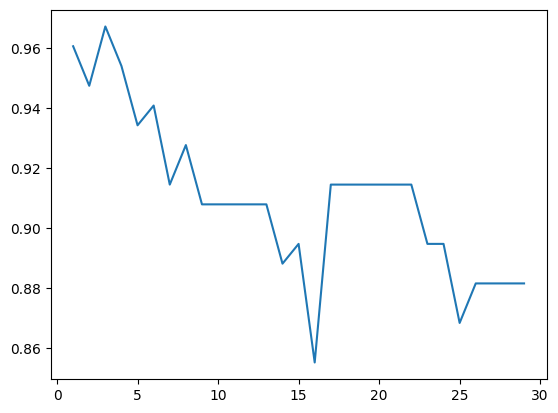

In [101]:
accuracies = []

for i in range(1, 30):
    knn = KNN(n_neighbors=i)

    knn.fit(X_train, y)

    labels = knn.predict(X_test)
    labels = np.where(labels, 1, 0)

    accuracies.append(np.mean(labels == boston_test["crim01"]))

import matplotlib.pyplot as plt

x_knn = range(1, 30)

fig, ax = plt.subplots()

ax.plot(x_knn, accuracies);

Most models—LDA, QDA, and Naive Bayes—show similar accuracies around 84.87%, with fairly balanced precision and recall for both classes. Logistic regression performs slightly better, achieving 87.50% accuracy and a good balance of precision and recall for both high-crime (class 1) and low-crime (class 0) groups. Notably, KNN with $K=3$ significantly outperforms the others, reaching 96.71% accuracy and very high precision and recall for both classes. This suggests that with NOX as the sole predictor, the local patterns captured by KNN provide a more accurate classification than the linear or parametric assumptions in the other methods. However, care should be taken to validate this performance, as KNN can be sensitive to overfitting with limited predictors.